__<span style="background-color:#ffffe0">第3章　時系列予測モデル構築・超入門</span>__

# 3.3　時系列の予測モデルを構築してみよう

##  3.3.6　Prophetで構築する予測モデル（ハイパーパラメータ自動探索）

### 準備（必要なモジュールとデータの読み込み）

In [1]:
#
# 必要なモジュールの読み込み
#

import numpy as np
import pandas as pd

from prophet import Prophet

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

from pmdarima.model_selection import train_test_split

import optuna

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフスタイル
plt.rcParams['figure.figsize'] = [12, 9] #グラフサイズ
plt.rcParams['font.size'] = 14 #フォントサイズ

In [2]:
#
# 必要なデータセット（時系列データ）の読み込み
#

dataset='AirPassengers.csv'  #データセットのファイル名
df = pd.read_csv(dataset)    #読み込み
df.columns = ['ds', 'y']     #日付：DS、目的変数：y

print(df) #確認

             ds    y
0    1949-01-01  112
1    1949-02-01  118
2    1949-03-01  132
3    1949-04-01  129
4    1949-05-01  121
..          ...  ...
139  1960-08-01  606
140  1960-09-01  508
141  1960-10-01  461
142  1960-11-01  390
143  1960-12-01  432

[144 rows x 2 columns]


code 3-39

In [3]:
#
# データセットを学習データとテストデータ（直近12ヶ月間）に分割
#

train, test = train_test_split(df, test_size=12)

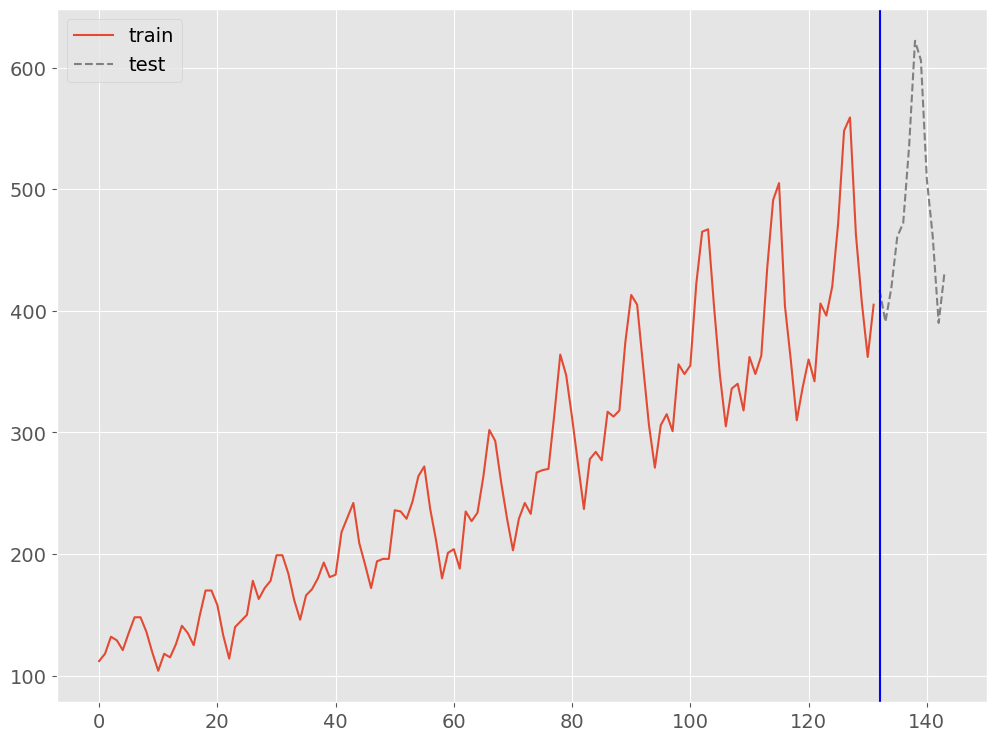

In [4]:
#
# グラフ（学習データとテストデータ）
#

fig, ax = plt.subplots()

# 学習データの描写
ax.plot(
    train.index, 
    train.y.values, 
    linestyle='-',
    label='train')

# テストデータの描写
ax.plot(
    test.index,
    test.y.values,
    linestyle='--',
    label='test',
    color='gray')

# 学習データとテスデータの間の縦線の描写
ax.axvline(
    132,
    color='blue')

# 凡例表示
ax.legend()

plt.show()

### 最適なハイパーパラメータの探索

In [5]:
# Optunaの目的関数の設定
def objective(trial):
    
    #ハイパーパラメータの探索範囲
    params = {'changepoint_prior_scale' : 
                 trial.suggest_uniform(
                     'changepoint_prior_scale',
                     0.001, 0.5),
              'seasonality_prior_scale' : 
                 trial.suggest_uniform(
                     'seasonality_prior_scale',
                     0.01, 10),
              'seasonality_mode' : 
                 trial.suggest_categorical(
                     'seasonality_mode',
                     ['additive', 'multiplicative']),
              'changepoint_range' : 
                  trial.suggest_discrete_uniform(
                      'changepoint_range',
                      0.8, 0.95, 0.001),
              'n_changepoints' : 
                  trial.suggest_int(
                      'n_changepoints',
                      20, 35),
             }
    
    #時系列CV
    ##CVのインスタンス生成　
    tss = TimeSeriesSplit(test_size=12)
    
    ##CVの結果を格納するハコ
    cv_mse = []
    
    ##CVの実行
    for fold, (train_index, valid_index) in enumerate(tss.split(train)):
        
        #データ分割
        train_data = train.iloc[train_index] #訓練データ
        valid_data = train.iloc[valid_index] #検証データ

        #モデルのインスタンス生成
        m = Prophet(**params)
        
        #学習
        m.fit(train_data)
    
        #予測
        df_future = m.make_future_dataframe(
            periods=len(valid_data),
            freq='M')
        df_pred = m.predict(df_future) 
        preds = df_pred.tail(len(valid_data))
    
        #精度評価（MSE）
        val_mse = mean_squared_error(
            valid_data.y,
            preds.yhat)
        cv_mse.append(val_mse)
    
    return np.mean(cv_mse)

# ログ非出力
optuna.logging.disable_default_handler()

# 最適なハイパーパラメータの探索
study = optuna.create_study(direction="minimize")

study.optimize(
    objective, 
    n_trials=1000, 
    n_jobs=-1)

# 最適ハイパーパラメータの出力
print(study.best_params)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to

{'changepoint_prior_scale': 0.4792357145582434, 'seasonality_prior_scale': 0.038158542067100565, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8200000000000001, 'n_changepoints': 34}


### 予測モデルの学習（学習データ利用）

In [6]:
#
# 予測モデルの学習（学習データ利用）
#

# インスタンスの生成
m = Prophet(**study.best_params)

# 学習
m.fit(train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### 予測モデルのテスト（テストデータ利用）

In [7]:
#
# 予測の実施
#

# 予測（学習データ期間＋テストデータ期間）
df_future = m.make_future_dataframe(
    periods=12,
    freq='M')
df_pred = m.predict(df_future) 

# 元のデータセットに予測値を結合
df['predicted'] = df_pred['yhat']

# 予測値
train_pred = df.iloc[:-12].loc[:,'predicted'] #学習データ期間
test_pred = df.iloc[-12:].loc[:,'predicted']  #テスデータ期間

In [8]:
#
# 予測精度（テストデータ）
#

print('RMSE:\n',
      np.sqrt(mean_squared_error(
          test.y, test_pred)))
print('MAE:\n',
      mean_absolute_error(
          test.y, test_pred)) 
print('MAPE:\n',
      mean_absolute_percentage_error(
          test.y, test_pred))

RMSE:
 17.19085607511075
MAE:
 14.04720106238994
MAPE:
 0.029072992444112117


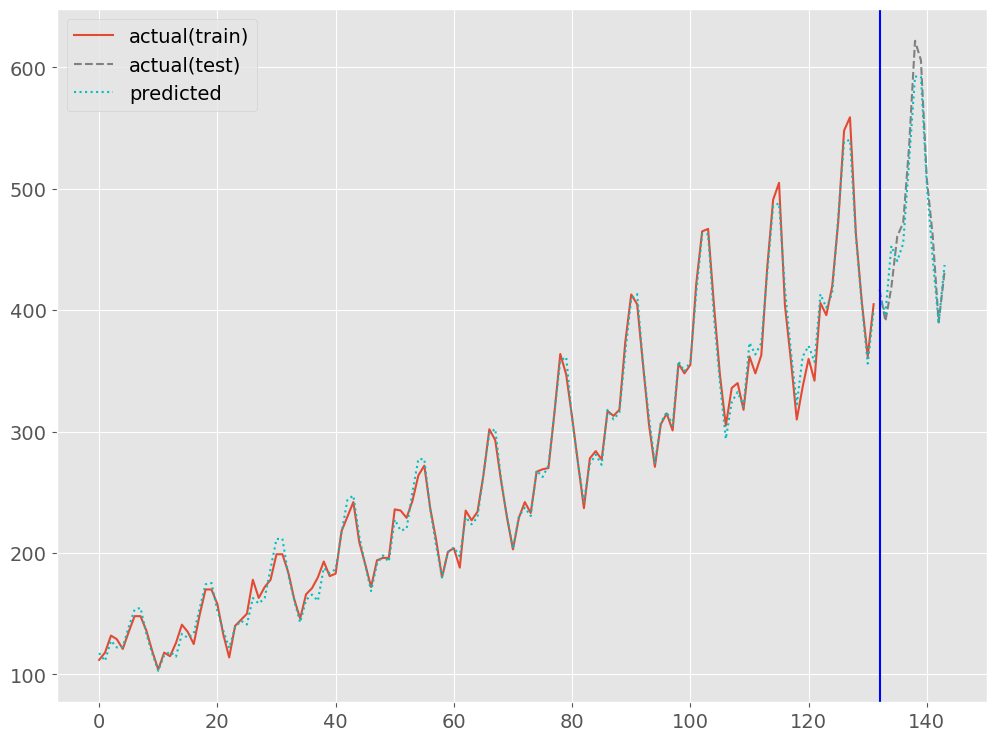

In [9]:
#
# グラフ（予測値と実測値）
#

fig, ax = plt.subplots()

# 実測値の描写
## 学習データ
ax.plot(
    train.index, 
    train.y,
    linestyle='-',
    label='actual(train)')

## テストデータ
ax.plot(test.index, 
        test.y, 
        linestyle='--',
        label='actual(test)', 
        color='gray')

# 予測値の描写
## 学習データ
ax.plot(
    train.index, 
    train_pred, 
    linestyle=':',
    color='c')

## テストデータ
ax.plot(
    test.index, 
    test_pred, 
    linestyle=':',
    label='predicted',
    color='c') 

# 学習データとテスデータの間の縦線の描写
ax.axvline(
    132,
    color='blue')

# 凡例表示
ax.legend()

plt.show()